In [3]:
# Load the model and preprocess test data (similar to training data preprocessing)
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
#Training Model
import os
import librosa
import numpy as np
labels = {}
def extract_features(audio_path, max_time_steps=109):
    X = []
    y = []

    for folder in os.listdir(audio_path):
        folder_path = os.path.join(audio_path, folder)
        label = 1 if folder == "Real" else 0  # Update label based on directory name
        
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            try:
                # Load audio file using librosa
                audio, _ = librosa.load(file_path, sr=16000, duration=3)

                # Extract Mel spectrogram using librosa
                mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000, n_mels=128)
                mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

                # Ensure all spectrograms have the same width (time steps)
                if mel_spectrogram.shape[1] < max_time_steps:
                    mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
                else:
                    mel_spectrogram = mel_spectrogram[:, :max_time_steps]

                X.append(mel_spectrogram)
                y.append(label)
                print(file_path)
            except Exception as e:
                print(f"Error encountered while processing file: {file_path}")
                continue

    return np.array(X), np.array(y)

# Example usage
audio_path = 'Traincnn'
X, y = extract_features(audio_path)

In [16]:
from keras.utils import to_categorical
X = np.array(X)
y = np.array(y)

X,y
y_encoded = to_categorical(y, 2)

In [32]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [18]:
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]

In [33]:
y_test1, y_val1 = y[:split_index], y[split_index:]

In [4]:

import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model


In [20]:
# Define CNN model architecture
N_MELS=128
input_shape = (N_MELS, X_train.shape[2], 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)

In [22]:

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(2, activation='softmax')(x)

In [23]:
model = Model(inputs=model_input, outputs=model_output)

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.9316 - loss: 12.6376 - val_accuracy: 0.9927 - val_loss: 0.0178
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 30s 192ms/step - accuracy: 0.9960 - loss: 0.0152 - val_accuracy: 0.9952 - val_loss: 0.0138
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 189ms/step - accuracy: 0.9952 - loss: 0.0123 - val_accuracy: 0.9887 - val_loss: 0.0343
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 189ms/step - accuracy: 0.9968 - loss: 0.0140 - val_accuracy: 0.9968 - val_loss: 0.0055
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 30s 194ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9984 - val_loss: 0.0020
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 30s 191ms/step - accuracy: 0.9981 - loss: 0.0065 - val_accuracy: 0.9935 - val_loss: 0.0207
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 189ms/step - accuracy: 0.9988 - loss: 0.0036 - val_accuracy: 0.9968 - val_loss: 0.0089
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 190ms/step - accuracy: 0.9986 - loss: 

In [26]:
# saving the model
model.save("audio_classifier_cnn.h5")

In [29]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
# Load and preprocess test data using librosa
X_test = []

test_files = os.listdir(TEST_DATASET_PATH)
for file_name in test_files:
    file_path = os.path.join(TEST_DATASET_PATH, file_name)

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X_test.append(mel_spectrogram)

# Convert list to numpy array
X_test = np.array(X_test)

# Predict using the loaded model
y_pred = model.predict(X_test)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[1.1361549e-03, 9.9886382e-01],
       [6.0165148e-05, 9.9993980e-01],
       [1.6117141e-01, 8.3882856e-01],
       [9.4402373e-01, 5.5976324e-02],
       [9.9997663e-01, 2.3319533e-05],
       [6.5947454e-03, 9.9340522e-01],
       [1.3998023e-01, 8.6001980e-01],
       [8.8895095e-04, 9.9911100e-01],
       [7.2926625e-05, 9.9992704e-01],
       [4.2612876e-07, 9.9999952e-01],
       [1.7187633e-06, 9.9999833e-01],
       [6.4715495e-09, 1.0000000e+00],
       [8.2506635e-04, 9.9917489e-01],
       [7.7339755e-03, 9.9226600e-01],
       [2.1664132e-03, 9.9783355e-01],
       [3.9733879e-02, 9.6026611e-01],
       [8.1424344e-01, 1.8575652e-01],
       [3.8978624e-01, 6.1021382e-01],
       [1.2324073e-02, 9.8767591e-01],
       [1.1153588e-01, 8.8846409e-01],
       [9.8852791e-02, 9.0114719e-01],
       [3.9366145e-07, 9.9999964e-01],
       [6.2269820e-03, 9.9377304e-01],
       [4.7326729e-01, 5.2673268e-01],
       [9.9987590e-01, 1.2404934e-04],
       [9.9614429e-01, 3.

In [25]:
y_pred_classes

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [34]:
y_val1

array([1, 1, 1, ..., 1, 1, 1])

In [30]:
# ROC Curve

from sklearn.metrics import roc_curve, auc

# Predict using the loaded model
y_pred = model.predict(X_test)

# Get the predicted probabilities for the positive class
y_pred_prob = y_pred[:, 1]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [45]:
y_val1

array([1, 1, 1, ..., 1, 1, 1])

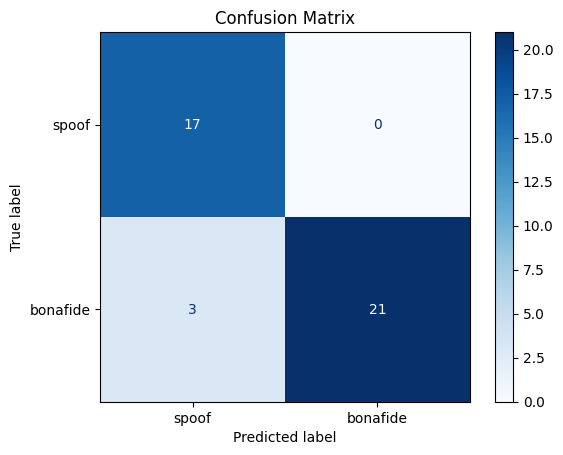

In [31]:
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
classes = ["spoof", "bonafide"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [46]:
y_pred_prob

array([0.99941885, 0.999522  , 0.9998964 , ..., 0.99839646, 0.99998784,
       0.99998045], dtype=float32)

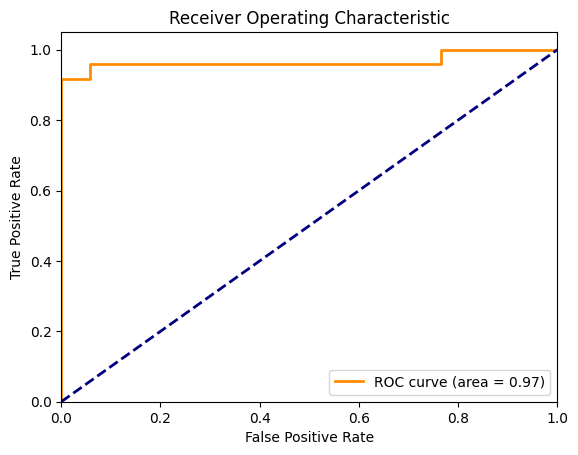

In [32]:

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [5]:
TEST_DATASET_PATH = "./Test_cnn"
MODEL_PATH = "audio_classifier_cnn.h5"  # Replace with the actual path to your saved model
SAMPLE_RATE = 16000
DURATION = 5
N_MELS = 128
MAX_TIME_STEPS = 109

In [6]:
# Load the saved model
model = load_model(MODEL_PATH)

In [17]:
# Load and preprocess test data using librosa
X_test = []

test_files = os.listdir(TEST_DATASET_PATH)
for file_name in test_files:
    file_path = os.path.join(TEST_DATASET_PATH, file_name)

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X_test.append(mel_spectrogram)

# Convert list to numpy array
X_test = np.array(X_test)

# Predict using the loaded model
y_pred = model.predict(X_test)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[1.1361549e-03, 9.9886382e-01],
       [6.0165148e-05, 9.9993980e-01],
       [1.6117141e-01, 8.3882856e-01],
       [9.4402373e-01, 5.5976324e-02],
       [9.9997663e-01, 2.3319533e-05],
       [6.5947454e-03, 9.9340522e-01],
       [1.3998023e-01, 8.6001980e-01],
       [8.8895095e-04, 9.9911100e-01],
       [7.2926625e-05, 9.9992704e-01],
       [4.2612876e-07, 9.9999952e-01],
       [1.7187633e-06, 9.9999833e-01],
       [6.4715495e-09, 1.0000000e+00],
       [8.2506635e-04, 9.9917489e-01],
       [7.7339755e-03, 9.9226600e-01],
       [2.1664132e-03, 9.9783355e-01],
       [3.9733879e-02, 9.6026611e-01],
       [8.1424344e-01, 1.8575652e-01],
       [3.8978624e-01, 6.1021382e-01],
       [1.2324073e-02, 9.8767591e-01],
       [1.1153588e-01, 8.8846409e-01],
       [9.8852791e-02, 9.0114719e-01],
       [3.9366145e-07, 9.9999964e-01],
       [6.2269820e-03, 9.9377304e-01],
       [4.7326729e-01, 5.2673268e-01],
       [9.9987590e-01, 1.2404934e-04],
       [9.9614429e-01, 3.

In [18]:
len(y_pred_classes)

41

In [19]:
y_pred_classes

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [22]:
y_true=np.array(y_true)

In [23]:
y_true

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
y_true = [1 if i < 24 else 0 for i in range(41)]

In [16]:
y_true 

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [60]:
len(y_pred_classes)

173